In [1]:
import tensorflow as tf
import numpy as np 
import cv2
import imutils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import time
IMG_SIZE=224

In [2]:
input_path= r'C:\Users\hp\Downloads\archive\brain_tumor_dataset'

In [3]:
def crop_img(image,tol=7):
    if image.ndim ==2:
        mask = image>tol
        return image[np.ix_(mask.any(1),mask.any(0))]
    elif image.ndim==3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = image[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return image
        else:
            img1=image[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=image[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=image[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [4]:
def preprocess_img(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_img(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,10), -4, 96)
    return image

In [5]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2,
                             preprocessing_function=preprocess_img
                            )

train_gen= datagen.flow_from_directory(input_path,
                                       target_size=(IMG_SIZE,IMG_SIZE),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( input_path,
                                       target_size=(IMG_SIZE,IMG_SIZE),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


# DenseNet121

In [6]:
from keras.applications import DenseNet121
Name = "Densenet"
tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))
densenet = tf.keras.applications.DenseNet121(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_densenet = tf.keras.Sequential()
model_densenet.add(densenet)
model_densenet.add(tf.keras.layers.GlobalAveragePooling2D())
model_densenet.add(tf.keras.layers.Dropout(0.5))
model_densenet.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  
model_densenet.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005),
        metrics=['BinaryAccuracy'])
  
filepath="densenet.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] + [tensorboard]
model_densenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


In [7]:
history_densenet =model_densenet.fit_generator(train_gen, 
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=val_gen,
                    callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
1/7 [===>..........................] - ETA: 0s - loss: 1.0917 - binary_accuracy: 0.4375WARNING:tensorflow:From E:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7/7 [==============================] - 155s 22s/step - loss: 0.8843 - binary_accuracy: 0.5271 - val_loss: 0.7306 - val_binary_accuracy: 0.5200
Epoch 2/30
7/7 [==============================] - 153s 22s/step - loss: 0.6811 - binary_accuracy: 0.6108 - val_loss: 0.8997 - val_binary_accuracy: 0.4000
Epoch 3/30
7/7 [==============================] - 153s 22s/step - loss: 0.4770 - binary_accuracy: 0.7783 - val_loss: 0.8331 - val_binary_accuracy: 0.4800
Epoch 4/30
7/7 [==============================] - 153s 22s/step - loss: 0.4062 - binary_accuracy

In [8]:
model_densenet.save('C:\\Users\\hp\\Downloads\\APTOS-2019-Blindness-Detection-master\\densenet.h5')

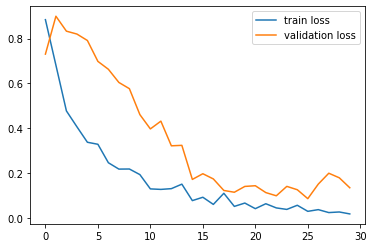

In [9]:
plt.plot(history_densenet.history['loss'],label='train loss')
plt.plot(history_densenet.history['val_loss'],label='validation loss')
plt.legend()

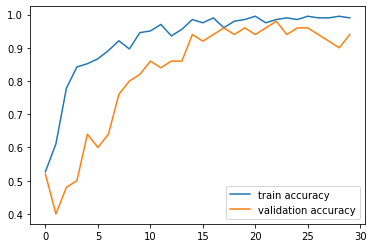

In [10]:
plt.plot(history_densenet.history['binary_accuracy'],label='train accuracy')
plt.plot(history_densenet.history['val_binary_accuracy'],label='validation accuracy')
plt.legend()

# Resnet50 

In [11]:
from keras_applications.resnet import ResNet50
Name = "Resnet"
tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))
resnet = tf.keras.applications.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
model_resnet = tf.keras.Sequential([
resnet,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model_resnet.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005),
        metrics=['BinaryAccuracy'])
    
filepath="Resnet50.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] + [tensorboard]
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
history_resnet =model_resnet.fit_generator(train_gen, 
                    epochs=30,
                    initial_epoch=0,
                    verbose=1, 
                    validation_data=val_gen,
                    callbacks=callbacks_list)


Epoch 1/30
7/7 [==============================] - 159s 23s/step - loss: 1.0249 - binary_accuracy: 0.4631 - val_loss: 1.6131 - val_binary_accuracy: 0.3800
Epoch 2/30
7/7 [==============================] - 140s 20s/step - loss: 0.5814 - binary_accuracy: 0.7044 - val_loss: 1.6125 - val_binary_accuracy: 0.3800
Epoch 3/30
7/7 [==============================] - 157s 22s/step - loss: 0.3227 - binary_accuracy: 0.8522 - val_loss: 1.6332 - val_binary_accuracy: 0.3800
Epoch 4/30
7/7 [==============================] - 138s 20s/step - loss: 0.3551 - binary_accuracy: 0.8424 - val_loss: 1.6767 - val_binary_accuracy: 0.3800
Epoch 5/30
7/7 [==============================] - 141s 20s/step - loss: 0.2480 - binary_accuracy: 0.8916 - val_loss: 1.6107 - val_binary_accuracy: 0.3800
Epoch 6/30
7/7 [==============================] - 156s 22s/step - loss: 0.1627 - binary_accuracy: 0.9458 - val_loss: 1.7657 - val_binary_accuracy: 0.3800
Epoch 7/30
7/7 [==============================] - 138s 20s/step - loss: 0.13

In [13]:
model_resnet.save('C:\\Users\\hp\\Downloads\\APTOS-2019-Blindness-Detection-master\\model_resnet.h5')


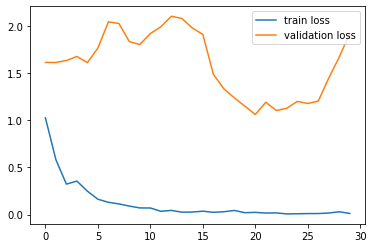

In [14]:
plt.plot(history_resnet.history['loss'],label='train loss')
plt.plot(history_resnet.history['val_loss'],label='validation loss')
plt.legend()

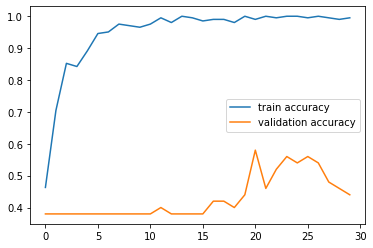

In [15]:
plt.plot(history_resnet.history['binary_accuracy'],label='train accuracy')
plt.plot(history_resnet.history['val_binary_accuracy'],label='validation accuracy')
plt.legend()

# EfficientnetB4 

In [16]:
from tensorflow.keras.applications import EfficientNetB4 as efn

SAVED_MODEL_NAME = 'effnet_modelB4.h5'
Name = "EfficientNetB4"
tensorboard = TensorBoard(log_dir='logs_new6\{}'.format(Name))
effnet = efn(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

model_effnet = tf.keras.Sequential([
effnet,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation='sigmoid')
])
       
model_effnet.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(lr=0.00005))

filepath = "effnet.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_kappa', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] + [tensorboard]
model_effnet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1792)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1793      
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________


In [17]:
history_effnet = model_effnet.fit_generator(train_gen,
                              epochs=30,
                              validation_data=val_gen,
                              callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - 294s 42s/step - loss: 0.7254 - val_loss: 0.6764
Epoch 2/30
7/7 [==============================] - 244s 35s/step - loss: 0.6394 - val_loss: 0.6892
Epoch 3/30
7/7 [==============================] - 241s 34s/step - loss: 0.5661 - val_loss: 0.6793
Epoch 4/30
7/7 [==============================] - 246s 35s/step - loss: 0.5366 - val_loss: 0.6709
Epoch 5/30
7/7 [==============================] - 228s 33s/step - loss: 0.4705 - val_loss: 0.6687
Epoch 6/30
7/7 [==============================] - 234s 33s/step - loss: 0.4468 - val_loss: 0.6651
Epoch 7/30
7/7 [==============================] - 229s 33s/step - loss: 0.3561 - val_loss: 0.6559
Epoch 8/30
7/7 [==============================] - 232s 33s/step - loss: 0.3393 - val_loss: 0.6403
Epoch 9/30
7/7 [==============================] - 243s 35s/step - loss: 0.3000 - val_loss: 0.6555
Epoch 10/30
7/7 [==============================] - 211s 30s/step - loss: 0.2961 - val_loss: 0.6471
Epoch 11/30
7/7 [==

In [18]:
model_effnet.save('C:\\Users\\hp\\Downloads\\APTOS-2019-Blindness-Detection-master\\model_effnet.h5')

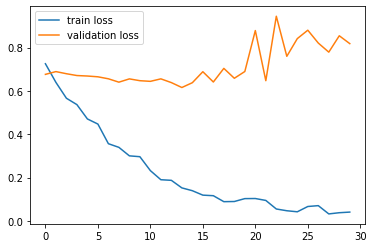

In [19]:
plt.plot(history_effnet.history['loss'],label='train loss')
plt.plot(history_effnet.history['val_loss'],label='validation loss')
plt.legend()

In [20]:
plt.plot(history_effnet.history['binary_accuracy'],label='train accuracy')
plt.plot(history_effnet.history['val_binary_accuracy'],label='validation accuracy')
plt.legend()

KeyError: 'binary_accuracy'